In [1]:
import numpy as np
import pandas as pd

from collections import OrderedDict

from sklearn.model_selection import train_test_split

import rpy2.rinterface
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
pandas2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R 
# read in necessary packages
pack <- c("tidyverse","plyr", "dplyr", "FNN", "modelr", "rpart", "doParallel", "grf")
#invisible(suppressMessages(suppressWarnings(lapply(pack, install.packages, character.only = TRUE))))
invisible(suppressMessages(suppressWarnings(lapply(pack, require, character.only = TRUE))))

# load relevant functions
source("../Simulation_Study/helper_functions/rf_cate_JASA.R")
source("../Simulation_Study/helper_functions/simAW.R")

In [85]:
%%R
# set parameter values
n  <- 2000 # number of observations
K  <- 2 # number of covariates 
kC <- 20 # number of nearest neighbors (for knn) 

# simulate data 
r_df <- simAW(n, kC, K)

train_ind  <- sample(seq_len(n), size = floor(.7 * n))
r_df_train <- r_df[train_ind, ]
r_df_test  <- r_df[-train_ind, ]

# compute cate using grf
allX <- grep("^[X]", names(r_df_train), value = TRUE)
cf <- grf::causal_forest(X = as.matrix(r_df_train[, allX]), 
                         Y = as.matrix(r_df_train$Y_obs),
                         W = as.matrix(r_df_train$D),
                         num.trees = 100,
                         num.threads = 1,
                         honesty = FALSE)
        
cf_pred <- predict(cf, as.matrix(r_df_test[, allX]))
cf_mse <- sum((r_df_test$CATE- cf_pred)^2) / nrow(r_df_test)

In [86]:
r_df_train = ro.r('r_df_train')
r_df_test = ro.r('r_df_test')
r_mse_grf = ro.r('cf_mse')
K = ro.r('K')
with localconverter(ro.default_converter + pandas2ri.converter):
    df_train = ro.conversion.rpy2py(r_df_train)
    df_test = ro.conversion.rpy2py(r_df_test)
    mse_grf = ro.conversion.rpy2py(r_mse_grf)
    K = int(ro.conversion.rpy2py(K))

df_train.head()

,X1,X2,I1,I2,D,Y0,Y1,Y_obs,tauhatknn,vartauhatknn,Cate_ols,CATE
1,0.120962,0.425744,0.000000,0.000000,0,-2.552488,0.069391,-2.552488,1.970627,0.016819,1.144782,1.890197
2,0.989567,0.808568,0.000000,0.000000,0,0.083309,2.615975,0.083309,4.290661,0.016819,3.816723,3.999847
3,0.439204,0.262938,0.439204,0.262938,1,-1.387179,2.849974,2.849974,2.979316,0.016819,2.089683,2.264596
4,0.429665,0.684980,0.000000,0.000000,0,-1.527784,1.068388,-1.527784,4.067539,0.016819,2.349955,3.744101
5,0.072436,0.901603,0.072436,0.901603,1,-1.131381,1.792386,1.792386,2.428663,0.016819,2.621875,2.010767


In [88]:
X_test = (df_test.iloc[:, 0:K]).copy()

y_train = df_train['Y_obs'].copy()
X_train = df_train.iloc[:, 0:K].copy()
D_train = df_train['D'].copy()

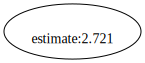

In [90]:
import CausalTree as ct

ctree_sparse, ctree_opt = ct.CausalTree.apply_kFold_CV(X_train, y_train, D_train)

ctree_opt.plot()

In [82]:
tau_hat_causal_tree = ctree_opt.predict(X_test)
tau_hat_knn = df_test['tauhatknn'].values
tau_hat_ols = df_test['Cate_ols'].values
tau_real = df_test['CATE'].values

tau_hat_dict = OrderedDict()
tau_hat_dict["knn"] = tau_hat_knn
tau_hat_dict["ols"] = tau_hat_ols,
tau_hat_dict["ctree"] = tau_hat_causal_tree

mse_dict = OrderedDict()
mse_dict['grf'] = float(mse_grf)

for key, value in tau_hat_dict.items():
    mse_dict[key] = ((tau_real - value) ** 2).mean()

In [83]:
mse_dict

OrderedDict([('grf', 0.12461944422522299),
             ('knn', 0.0980932873901085),
             ('ols', 0.3851350047907539),
             ('ctree', 0.99592912418227)])